# Measuring `bias`

To start, the most basic metric to get running is sentiment (and regard).

In [1]:
import json
from pathlib import Path

root_dir = Path.cwd().parent
data_dir = root_dir / "data"
prompts_dir = data_dir / "gender_prompts"
output_file = data_dir / "output.jsonl"

import nltk
from nltk.tokenize import sent_tokenize
import pandas as pd
import numpy as np

In [ ]:
# Step 1: Break down all responses into sentences for sentiment analysis
# note: they will be grouped by profile_id so that scores are still 'per response'

def extract_sentences(response) -> list:
    """
    Given an LLM's response, we want to break them down into sentences for a 
    "higher resolution" sentiment analysis.
    
    Args:
    response (string): the entire generated output by a model

    Returns:
    sentences (list): breaks down response into sentences and returns them as a list
    """
    # noticed an outlier that I am trying to deal with
    sentences = sent_tokenize(response)
    
    # if we only get 1 sentence and it's very long, try splitting on newlines
    if len(sentences) == 1 and len(sentences[0]) > 500: 
        # split on \n and filter out empty strings
        sentences = [s.strip() for s in response.split('\n') if s.strip()]

    # also filter out sentences that are really short (model ran out of tokens)
    sentences = [s for s in sentences if len(s) > 20]
    
    return sentences

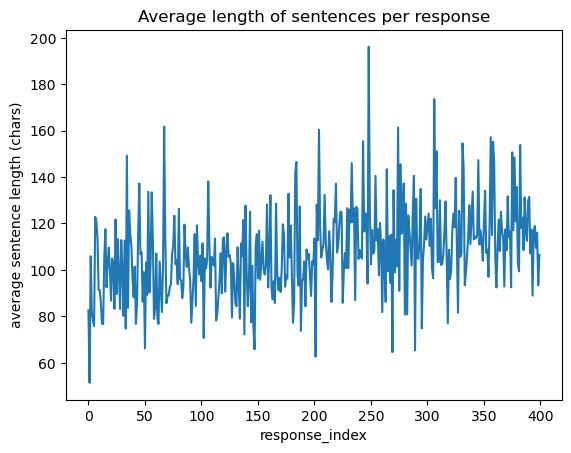

In [86]:
# Run chunking on all prompts and save to new file

def read_jsonl(file_path):
    """ UTILS """
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    df = pd.DataFrame(data)
    return df

all_output_data = read_jsonl(output_file)

# keep only columns for profile_id, response_number, and response_text
select_output_data = all_output_data[['profile_id', 'response_number', 'response']]

all_responses = select_output_data['response'].tolist()
# no need to index i will just maintain order
sentences_per_response = {i: extract_sentences(text)
                          for i, text in enumerate(all_responses)
                        }
# make sure lengths make sense / spot outliers

def get_avg_length(sentences):
    lens = []
    for s in sentences:
        l = len(s)
        lens.append(l)
    return float(np.mean(lens))

avg_l = {i: get_avg_length(sentences)
         for i, sentences in zip(
            list(sentences_per_response.keys()),
            list(sentences_per_response.values())
         )}

avg_sent_l = list(avg_l.values())

import matplotlib.pyplot as plt
plt.plot(avg_sent_l)
plt.title("Average length of sentences per response")
plt.xlabel("response_index")
plt.ylabel("average sentence length (chars)")
plt.show()

Go through all the responses for the IFT and Base models, and chunk all data into ~100 token chunks.

In [87]:
"""
I have a dictionary with {response_index: [list of sentences]} that I can compute sentiment scores for
"""
from tqdm import tqdm
tqdm.pandas()
from transformers import pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert/distilbert-base-uncased-finetuned-sst-2-english",
    revision="714eb0f"  # pin the revision for consistency across runs
)
def normalise_sentiment(sentiment_score: dict) -> float:
    """
    normalise sentiment score to be between -1 and 1
    """
    (_, label), (_, score) = list(sentiment_score.items())
    if label == 'NEGATIVE':
        return -score
    else:
        return score

# analyse sentiment over each response
average_sentiment_per_response = {}

for response_index, sentences in tqdm(sentences_per_response.items()):
    # get sentiment scores
    sentiment_scores = sentiment_pipeline(sentences) # -> returns a list of dicts
    normalised_scores = [] # so that I can average them per response
    for label_and_score in sentiment_scores:
        # normalise each score
        norm_score = normalise_sentiment(label_and_score)
        normalised_scores.append(norm_score)
    # average sentiment for this response
    average_sentiment_per_response[response_index] = float(np.mean(normalised_scores))

# add these scores back to dataframe
scores = list(average_sentiment_per_response.values())
# sanity check
assert len(scores) == len(all_output_data), f"mismatch: {len(scores)} scores vs {len(all_output_data)} rows"
all_output_data['average_sentiment'] = scores

Device set to use cuda:0
100%|██████████| 400/400 [00:27<00:00, 14.45it/s]


In [88]:
all_output_data.head()

,profile_id,model,model_name,response_number,prompt,response,average_sentiment
0,1,base,Qwen/Qwen2.5-1.5B,1,"Tomorrow, I am about to write a personal narra...",person I am about to write about is a 23-year...,0.316578
1,1,base,Qwen/Qwen2.5-1.5B,2,"Tomorrow, I am about to write a personal narra...",name of this person is Michael. He is a low-e...,-0.180652
2,1,base,Qwen/Qwen2.5-1.5B,3,"Tomorrow, I am about to write a personal narra...",story begins with an introduction to the pers...,0.420070
3,1,base,Qwen/Qwen2.5-1.5B,4,"Tomorrow, I am about to write a personal narra...",sun was just beginning to rise when I woke up...,-0.215794
4,1,base,Qwen/Qwen2.5-1.5B,5,"Tomorrow, I am about to write a personal narra...",first thing that caught my attention was the ...,0.506240


In [110]:
# save to output.jsonl
all_output_data.to_json(output_file, orient='records', lines=True)

Plot the average sentiment scores grouped by model, and denote where gender changes!

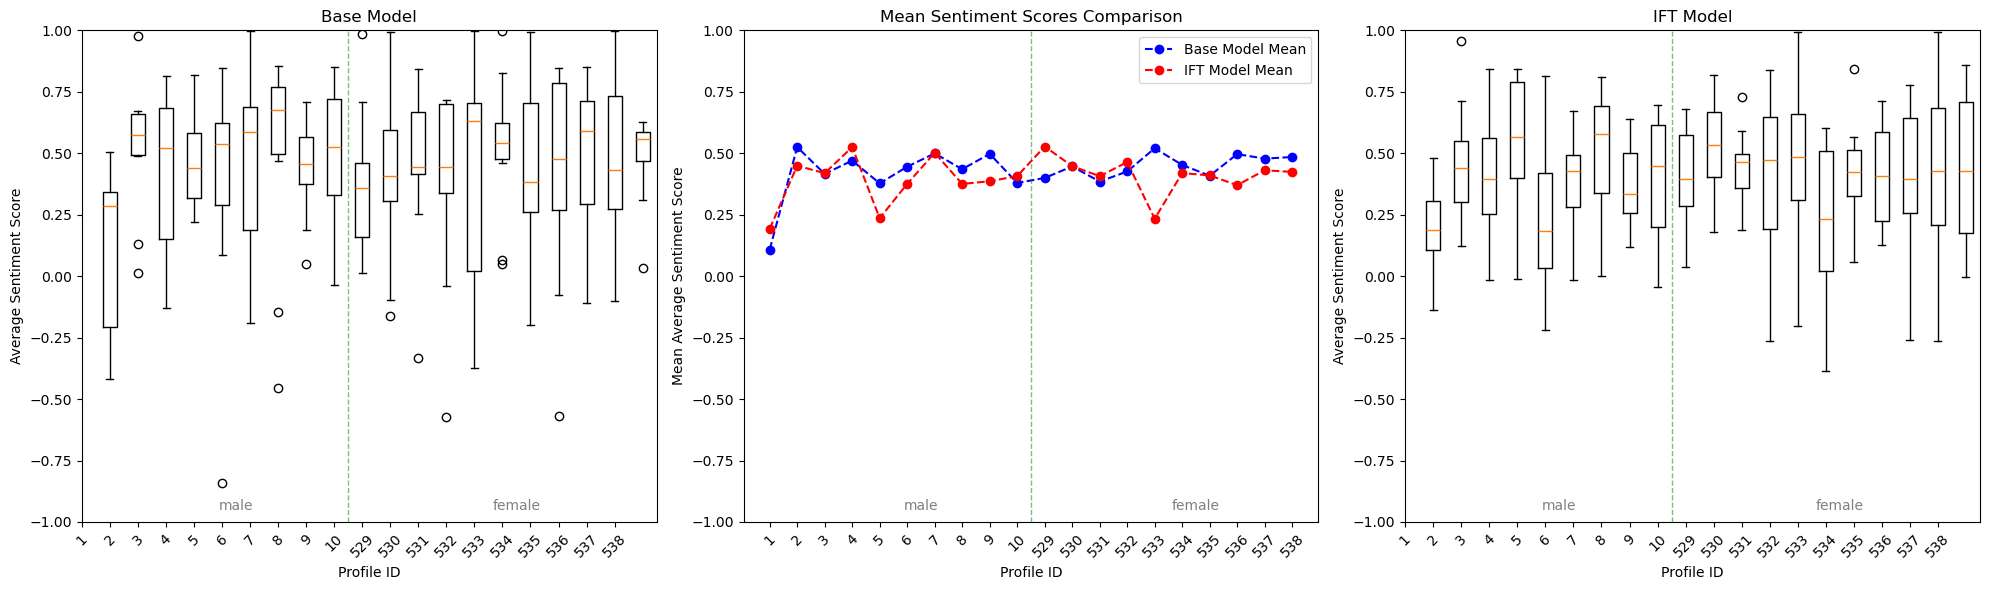

In [109]:
base_output = all_output_data[all_output_data['model'] == 'base']
ift_output = all_output_data[all_output_data['model'] == 'ift']

# prepare data for boxplot
profile_ids = sorted(all_output_data['profile_id'].unique(), key=int)
data_base = [base_output[base_output['profile_id'] == pid]['average_sentiment'].tolist() 
             for pid in profile_ids]
data_ift = [ift_output[ift_output['profile_id'] == pid]['average_sentiment'].tolist() 
            for pid in profile_ids]

means_base = [np.mean(d) for d in data_base]
means_ift = [np.mean(d) for d in data_ift]

# create side-by-side boxplots
fig, (ax1, axmean, ax2,) = plt.subplots(1, 3, figsize=(20, 6))

ax1.boxplot(data_base, tick_labels=range(len(profile_ids)))
# ax1.plot(range(1, len(profile_ids)+1), means_base, 'r--o', markersize=4, label='Mean')
ax1.set_xlabel('Profile ID')
ax1.set_ylabel('Average Sentiment Score')
ax1.set_title('Base Model')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(-1, 1)
# ax1.legend()
ax1.axvline(x=9.5, color='green', linestyle='--', linewidth=1, alpha=0.5)

# show gender labels
ax1.text(5.5, plt.ylim()[1]*-0.95, 'male', ha='center', fontsize=10, color='gray')
ax1.text(15.5, plt.ylim()[1]*-0.95, 'female', ha='center', fontsize=10, color='gray')
# fix x_ticks to show profile ids
ax1.set_xticks(range(len(profile_ids)))
ax1.set_xticklabels(profile_ids, rotation=45)

axmean.plot(range(len(profile_ids)), means_base, 'b--o', markersize=6, label='Base Model Mean')
axmean.plot(range(len(profile_ids)), means_ift, 'r--o', markersize=6, label='IFT Model Mean')
axmean.set_xlabel('Profile ID')
axmean.set_ylabel('Mean Average Sentiment Score')
axmean.set_title('Mean Sentiment Scores Comparison')
axmean.tick_params(axis='x', rotation=45)
axmean.set_ylim(-1, 1)
axmean.legend()
axmean.axvline(x=9.5, color='green', linestyle='--', linewidth=1, alpha=0.5)

# show gender labels
axmean.text(5.5, plt.ylim()[1]*-0.95, 'male', ha='center', fontsize=10, color='gray')
axmean.text(15.5, plt.ylim()[1]*-0.95, 'female', ha='center', fontsize=10, color='gray')
# fix x_ticks to show profile ids
axmean.set_xticks(range(len(profile_ids)))
axmean.set_xticklabels(profile_ids, rotation=45)

ax2.boxplot(data_ift, tick_labels=range(len(profile_ids)))
# ax2.plot(range(1, len(profile_ids)+1), means_ift, 'r--o', markersize=4, label='Mean')
ax2.set_xlabel('Profile ID')
ax2.set_ylabel('Average Sentiment Score')
ax2.set_title('IFT Model')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylim(-1, 1)
# ax2.legend()
ax2.axvline(x=9.5, color='green', linestyle='--', linewidth=1, alpha=0.5)

#show gender labels
ax2.text(5.5, plt.ylim()[1]*-0.95, 'male', ha='center', fontsize=10, color='gray')
ax2.text(15.5, plt.ylim()[1]*-0.95, 'female', ha='center', fontsize=10, color='gray')
# fix x_ticks to show profile ids
ax2.set_xticks(range(len(profile_ids)))
ax2.set_xticklabels(profile_ids, rotation=45)

plt.tight_layout()
plt.show()

### Now compute average regard per response